# Final Project 
by,
### Mayank Grover -> mg5229
### Supreeth Sundar -> ss11346

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import random
import math
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
zero_seconds = timedelta(seconds=0)

In [4]:
# Read data
data = pd.read_csv("./data.csv", infer_datetime_format=True, header=0, parse_dates=[0], low_memory=False)

In [ ]:
# plotting Sample Market tick data
plt.figure(figsize= (20,11.25))
sample_data = data[0:10000] 
plt.title("BID-ASK Spread (sample_data)", fontsize = 25)
plt.plot(sample_data.DateTime,sample_data.Ask,label = 'Ask',color = 'g')
plt.plot(sample_data.DateTime,sample_data.Bid,label = 'Bid',color = 'r')
plt.legend(loc = 2, fontsize = 25)
plt.xlabel('Datetime', fontsize = 25)
plt.ylabel('GBP/USD', fontsize = 25)
plt.show()

In [ ]:
# Read order data
orders = pd.read_csv("./MMOrderSet.csv", infer_datetime_format=True, header=0, parse_dates=[1], low_memory=False)

In [ ]:
# Add additional relevant columns for easy computation
data['SpreadMid'] = round((data['Ask'] + data['Bid']) / 2,5)
data['BOSpread'] = round((data['Ask'] - data['Bid']),5)

In [ ]:
# Sanity check - tick data

print(data.head())
print('\nShape: ', data.shape)
print('\nInfo: ')
print(data.info())

In [ ]:
# Glancing at order data
orders.head()

## Creating Market bid and ask prices using Tick Data
For each tick data we get we check our inventory we provide our bid-ask prices limiting conditions

In [ ]:
# Variables

tick_data = data
order_data = orders

# x ms reaction time delay/lag
reaction_time_x = 10
reaction_time_x = timedelta(milliseconds=reaction_time_x)

# y ms order succession time
order_succession_time_y = 5
order_succession_time_y = timedelta(milliseconds=order_succession_time_y)

# Probabilities of execution
outside_exec_probability = 0
at_exec_probability = 0.5
inside_exec_first_prob = 1
inside_exec_follow_up_prob = 0.25

# Net Open Position Limit - million dollars
open_position_limit = 10.0
safe_open_pos_limit = open_position_limit * 0.5
soft_open_pos_limit = open_position_limit * 0.8
hard_open_pos_limit = open_position_limit * 0.9

# signal - list of [Ask signal, Bid signal] where both the signals could be 
# -2, -1, 0, 1, 2 representing inside, at, or outside the market.
signal = [-1, -1]

mm_tick_data = [] # first, second, third col = DateTime, Bid, Ask
cumulative_pnl = 0
open_risk_position = 0

market_tick_i = 0
order_data_index = 0

# mm_vs_m = ['inside', 'outside', 'at']
mm_vs_m = None

# Is this order the second order to be executed inside market and comes within x ms of the previous order
second_inside_order = False

# Variables required for setting/using "second_inside_order"
last_inside_order_exec_time = None
last_inside_order_exec_side = None

# Final Trade data - Made from order_data with added stats
trade_data = pd.DataFrame(index=range(order_data.shape[0]), \
                          columns=['Time', 'Side', 'Market_Bid', 'Market_Ask', 'Market_Mid', \
                          'MM_Bid', 'MM_Ask', 'MM_Mid', 'MM_Position_vs_Mkt', 'MM_Exec_price', \
                          'Execution_Prob', 'Executed', 'MM_PNL_Mil$', 'Cum_PNL_Mil$', 'Open_Risk_Mil$'])

last_order_gen_time = 0

one_pip = 0.0001

tick_data_index_increased = True

tick_index = 0
while tick_index < len(tick_data):
    
    tick = tick_data.loc[tick_index]
    
    # Update price for next tick if the market tick data index increased
    # If this is not done, we'll append new prices for the exact same time.
    next_mm_bid_price = None
    next_mm_ask_price = None
    next_mm_tick_time = None
    if signal[0] == -2:
        next_mm_ask_price = tick['Ask'] - one_pip
    elif signal[0] == -1:
        next_mm_ask_price = tick['Ask'] - 0.5 * one_pip
    elif signal[0] == 0:
        next_mm_ask_price = tick['Ask']
    elif signal[0] == 1:
        next_mm_ask_price = tick['Ask'] + 1.5 * one_pip
    else:
        next_mm_ask_price = tick['Ask'] + 5 * one_pip
    if signal[1] == -2:
        next_mm_bid_price = tick['Bid'] + one_pip
    elif signal[1] == -1:
        next_mm_bid_price = tick['Bid'] + 0.5 * one_pip
    elif signal[1] == 0:
        next_mm_bid_price = tick['Bid']
    elif signal[1] == 1:
        next_mm_bid_price = tick['Bid'] - 1.5 * one_pip
    else:
        next_mm_bid_price = tick['Bid'] - 5 * one_pip
    
    # Sanity - so that we don't lose money on execution
    if tick['BOSpread'] <= 0:
        next_mm_ask_price = tick['SpreadMid'] + 0.5 * one_pip
        next_mm_bid_price = tick['SpreadMid'] - 0.5 * one_pip
            
    if tick_data_index_increased:
        next_mm_tick_time = tick['DateTime'] + reaction_time_x
        mm_tick_data.append([next_mm_tick_time, next_mm_bid_price, next_mm_ask_price])
    else:
        # Update tick data according to last order time.
        if last_order_executed:
            if signal[0] == -2:
                next_mm_ask_price = last_mkt_ask_price - one_pip
            elif signal[0] == -1:
                next_mm_ask_price = last_mkt_ask_price - 0.5 * one_pip
            elif signal[0] == 0:
                next_mm_ask_price = last_mkt_ask_price
            elif signal[0] == 1:
                next_mm_ask_price = last_mkt_ask_price + 1.5 * one_pip
            else:
                next_mm_ask_price = last_mkt_ask_price + 5 * one_pip
            if signal[1] == -2:
                next_mm_bid_price = last_mkt_bid_price + one_pip
            elif signal[1] == -1:
                next_mm_bid_price = last_mkt_bid_price + 0.5 * one_pip
            elif signal[1] == 0:
                next_mm_bid_price = last_mkt_bid_price
            elif signal[1] == 1:
                next_mm_bid_price = last_mkt_bid_price - 1.5 * one_pip
            else:
                next_mm_bid_price = last_mkt_bid_price - 5 * one_pip
            
            # Sanity
            spread = next_mm_ask_price - next_mm_bid_price
            if spread <= 0:
                next_mm_ask_price = last_mkt_ask_price + 0.5 * one_pip
                next_mm_bid_price = last_mkt_bid_price - 0.5 * one_pip
                
            next_mm_tick_time = last_order_gen_time + reaction_time_x
            mm_tick_data.append([next_mm_tick_time, next_mm_bid_price, next_mm_ask_price])
            
    
    # current_market_tick_i : the index of the market tick associated with the current order
    current_market_tick_i = None
    
    # Get current order generation time
    order_gen_time = order_data.loc[order_data_index]['Time']
    
    tick_data_index_increased = False
    if order_gen_time > tick['DateTime']:
        # There are no orders currently, keep processing tick data
        tick_index += 1
        tick_data_index_increased = True
        continue
    elif order_gen_time == tick['DateTime']:
        current_market_tick_i = tick_index
    else:
        current_market_tick_i = tick_index - 1 if tick_index > 0 else 0
        
    # Variables / Stats for this order
    order_executed = None
    order_side = order_data.loc[order_data_index]['Side']
    exec_probabilty = None
    # mm_vs_m = ['inside', 'outside', 'at'] : Indication of whether for the current order,
    # we are more or less competetive than the market.
    mm_vs_m = None
    mm_pnl = None
    
    # mm_tick_i : Index of current market maker tick associated with the current order
    current_mm_tick_i = None
    for mm_tick_i in range(len(mm_tick_data)-1, -1, -1):
        if mm_tick_data[mm_tick_i][0] <= order_gen_time:
            current_mm_tick_i = mm_tick_i
            break
    
    # Market mid price offered by top of the book Market
    mkt_mid_price = tick_data.loc[current_market_tick_i]['SpreadMid']
    
    # Market Execution price offered by the market maker
    mm_exec_price = None
    
    # Check order type and assign 
    # Buy Order
    if order_side == 'B':
        if mm_tick_data[current_mm_tick_i][2] < tick_data.loc[current_market_tick_i]['Ask']:
            mm_vs_m = 'inside'
            mm_exec_price = mm_tick_data[current_mm_tick_i][2]
        elif mm_tick_data[current_mm_tick_i][2] == tick_data.loc[current_market_tick_i]['Ask']:
            mm_vs_m = 'at'
            mm_exec_price = mm_tick_data[current_mm_tick_i][2]
        else:
            mm_vs_m = 'outside'
    # Sell Order
    else:
        if mm_tick_data[current_mm_tick_i][1] > tick_data.loc[current_market_tick_i]['Bid']:
            mm_vs_m = 'inside'
            mm_exec_price = mm_tick_data[current_mm_tick_i][1]
        elif mm_tick_data[current_mm_tick_i][1] == tick_data.loc[current_market_tick_i]['Bid']:
            mm_vs_m = 'at'
            mm_exec_price = mm_tick_data[current_mm_tick_i][1]
        else:
            mm_vs_m = 'outside'
    
    # Actually execute order according to corresponding probability
    if mm_vs_m == 'outside':
        exec_probabilty = outside_exec_probability
        order_executed = False
    elif mm_vs_m == 'at':
        exec_probabilty = at_exec_probability
        if random.random() < exec_probabilty:
            order_executed = True
        else:
            order_executed = False
    elif mm_vs_m == 'inside':
        # set second_indside_order
        if last_inside_order_exec_side == order_side and \
        order_gen_time <= last_inside_order_exec_time + reaction_time_x:
            second_inside_order = True
        else:
            second_inside_order = False    
        if second_inside_order:
            exec_probabilty = inside_exec_follow_up_prob
            if random.random() < exec_probabilty:
                order_executed = True
            else:
                order_executed = False
        else:
            exec_probabilty = inside_exec_first_prob
            last_inside_order_exec_time = order_gen_time
            last_inside_order_exec_side = order_side
            if random.random() < exec_probabilty:
                order_executed = True
            else:
                order_executed = False
    
    if order_executed:
        if order_side == 'B':
            mm_pnl = mm_exec_price - tick_data.loc[current_market_tick_i]['SpreadMid']
            open_risk_position = open_risk_position - 1 
        else:
            mm_pnl = tick_data.loc[current_market_tick_i]['SpreadMid'] - mm_exec_price
            open_risk_position = open_risk_position + 1
    else:
        mm_pnl = 0
    
    trade_data.loc[order_data_index, 'Time'] = order_gen_time
    trade_data.loc[order_data_index, 'Side'] = order_side
    trade_data.loc[order_data_index, 'Market_Bid'] = tick_data.loc[current_market_tick_i]['Bid']
    trade_data.loc[order_data_index, 'Market_Ask'] = tick_data.loc[current_market_tick_i]['Ask']
    trade_data.loc[order_data_index, 'Market_Mid'] = tick_data.loc[current_market_tick_i]['SpreadMid']
    trade_data.loc[order_data_index, 'MM_Bid'] = mm_tick_data[current_mm_tick_i][1]
    trade_data.loc[order_data_index, 'MM_Ask'] = mm_tick_data[current_mm_tick_i][2]
    trade_data.loc[order_data_index, 'MM_Mid'] = (mm_tick_data[current_mm_tick_i][1] + \
                                                  mm_tick_data[current_mm_tick_i][2]) / 2.0
    trade_data.loc[order_data_index, 'MM_Position_vs_Mkt'] = mm_vs_m
    trade_data.loc[order_data_index, 'MM_Exec_price'] = mm_exec_price
    trade_data.loc[order_data_index, 'Execution_Prob'] = exec_probabilty
    trade_data.loc[order_data_index, 'Executed'] = order_executed
    trade_data.loc[order_data_index, 'MM_PNL_Mil$'] = mm_pnl
    cumulative_pnl += mm_pnl
    trade_data.loc[order_data_index, 'Cum_PNL_Mil$'] = cumulative_pnl
    trade_data.loc[order_data_index, 'Open_Risk_Mil$'] = open_risk_position
    
    trade_data.loc[order_data_index, 'Mkt_tick_time'] = tick_data.loc[current_market_tick_i, 'DateTime']
    trade_data.loc[order_data_index, 'MM_tick_time'] = mm_tick_data[current_mm_tick_i][0]

    
    # Logic for setting the price according to open price etc.
    # signal = [Ask, Bid]
    if open_risk_position >= 0:
        if open_risk_position < safe_open_pos_limit:
            signal = [-1, -1]
        elif open_risk_position < soft_open_pos_limit:
            signal = [-1, 0]
        else:
            signal = [-2, 2]
    else:
        if open_risk_position > -safe_open_pos_limit:
            signal = [-1, -1]
        elif open_risk_position > -soft_open_pos_limit:
            signal = [0, -1]
        else:
            signal = [2, -2]
            
    
    # Be ready for next order
    last_order_executed = order_executed
    last_order_gen_time = order_gen_time
    last_mkt_bid_price = trade_data.loc[order_data_index, 'Market_Bid']
    last_mkt_ask_price = trade_data.loc[order_data_index, 'Market_Ask']
    order_data_index += 1
    
    # All orders have been executed
    if order_data_index == len(order_data):
        break
    

In [19]:
trade_data.head(10)

,Time,Side,Market_Bid,Market_Ask,Market_Mid,MM_Bid,MM_Ask,MM_Mid,MM_Position_vs_Mkt,MM_Exec_price,Execution_Prob,Executed,MM_PNL_Mil$,Cum_PNL_Mil$,Open_Risk_Mil$,Mkt_tick_time,MM_tick_time
0,2018-01-07 22:04:12,B,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.3561,1,True,0.00024,0.00024,-1,2018-01-07 22:04:07.235,2018-01-07 22:04:07.245
1,2018-01-07 22:04:13,S,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.35563,1,True,0.00023,0.00047,0,2018-01-07 22:04:07.235,2018-01-07 22:04:12.010
2,2018-01-07 22:04:14,B,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.3561,1,True,0.00024,0.00071,-1,2018-01-07 22:04:07.235,2018-01-07 22:04:13.010
3,2018-01-07 22:04:15,S,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.35563,1,True,0.00023,0.00094,0,2018-01-07 22:04:07.235,2018-01-07 22:04:14.010
4,2018-01-07 22:04:16,B,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.3561,1,True,0.00024,0.00118,-1,2018-01-07 22:04:07.235,2018-01-07 22:04:15.010
5,2018-01-07 22:04:17,B,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.3561,1,True,0.00024,0.00142,-2,2018-01-07 22:04:07.235,2018-01-07 22:04:16.010
6,2018-01-07 22:04:18,B,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.3561,1,True,0.00024,0.00166,-3,2018-01-07 22:04:07.235,2018-01-07 22:04:17.010
7,2018-01-07 22:04:19,S,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.35563,1,True,0.00023,0.00189,-2,2018-01-07 22:04:07.235,2018-01-07 22:04:18.010
8,2018-01-07 22:04:20,S,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.35563,1,True,0.00023,0.00212,-1,2018-01-07 22:04:07.235,2018-01-07 22:04:19.010
9,2018-01-07 22:04:21,S,1.35558,1.35615,1.35586,1.35563,1.3561,1.35587,inside,1.35563,1,True,0.00023,0.00235,0,2018-01-07 22:04:07.235,2018-01-07 22:04:20.010


In [15]:
mm_tick_data_df = pd.DataFrame(mm_tick_data,columns=['DateTime', 'Bid', 'Ask'])

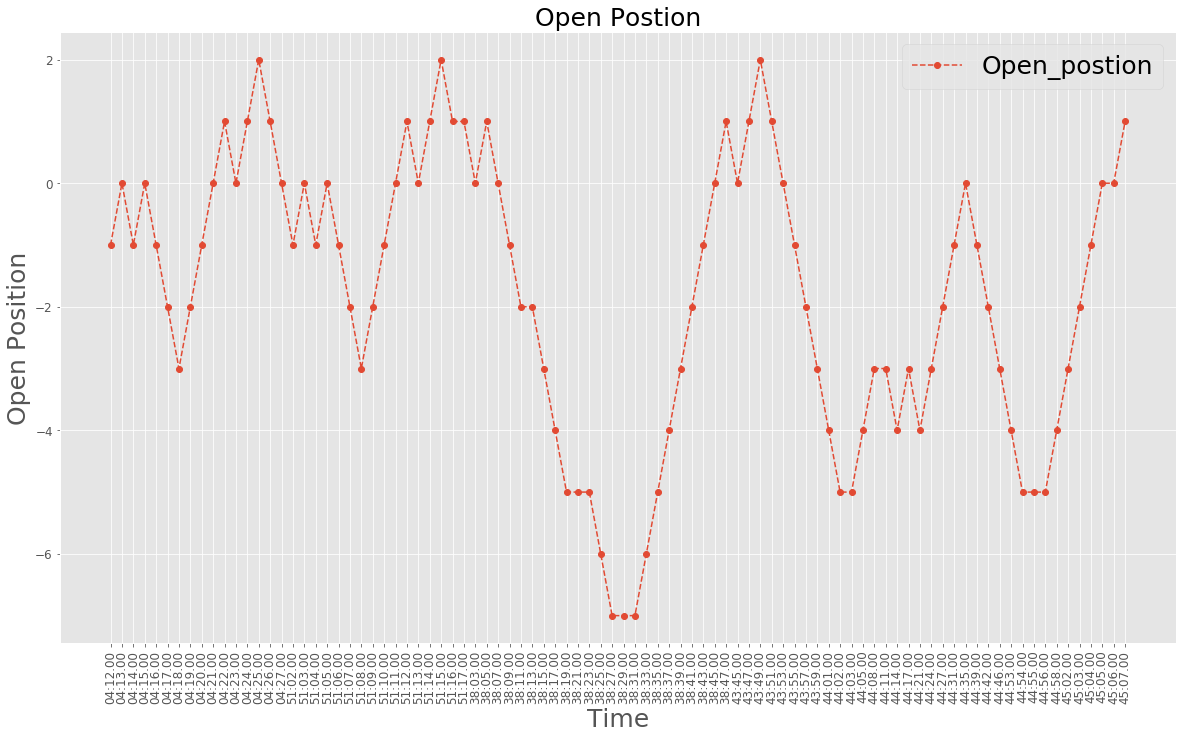

In [16]:
open_position = trade_data.loc[:,['Time','Open_Risk_Mil$']]
time_second = [open_position['Time'][i].strftime('%M:%S.%f')[:-4] 
 for i in range(len(trade_data))]
plt.figure(figsize= (20,11.25))
plt.title("Open Postion",fontsize = 25)
plt.plot(time_second,open_position.loc[:]['Open_Risk_Mil$'],'o--',label = 'Open_postion')
plt.legend(loc = 0, fontsize = 25)
plt.xlabel('Time', fontsize = 25)
plt.ylabel('Open Position', fontsize = 25)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=90)
plt.show()

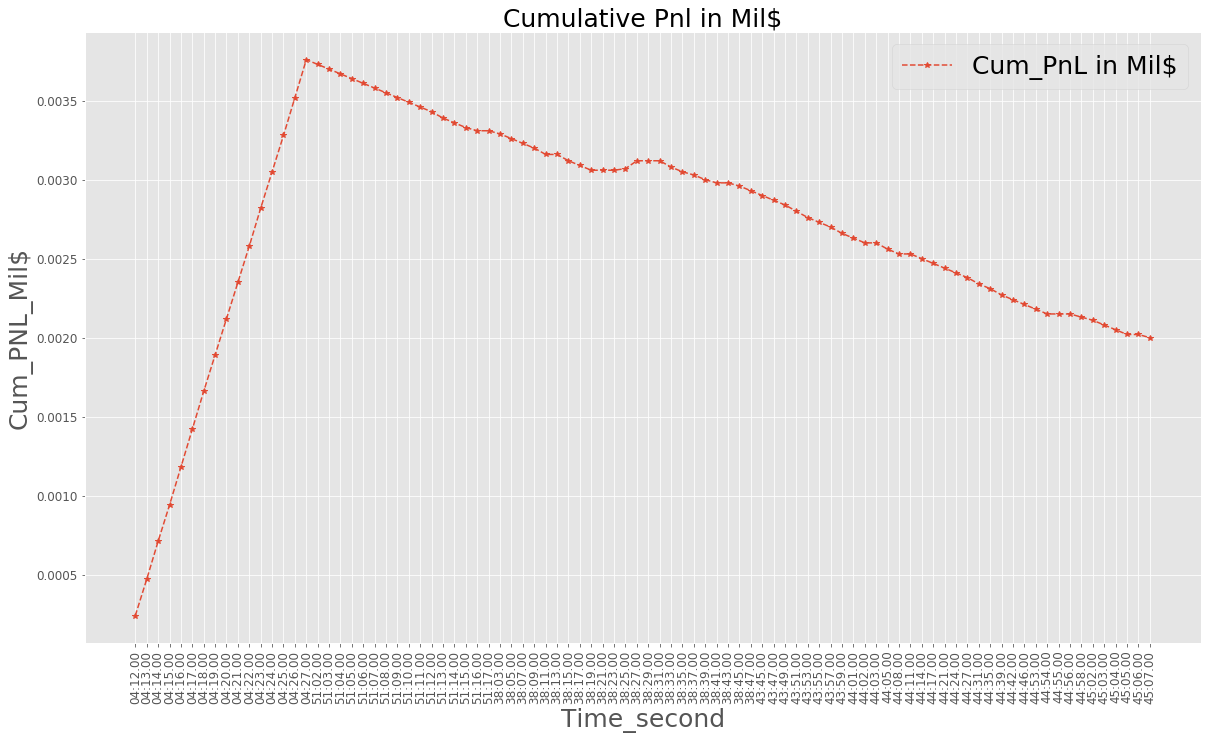

In [17]:
# plotting Cummulative PnL
cum_pnl = trade_data.loc[:,['Time','Cum_PNL_Mil$']]
plt.figure(figsize= (20,11.25))
plt.title("Cumulative Pnl in Mil$",fontsize = 25)

plt.plot(time_second,trade_data.loc[:]['Cum_PNL_Mil$'],'*--',label = 'Cum_PnL in Mil$')
plt.legend(loc = 0, fontsize = 25)
plt.xlabel('Time_second', fontsize = 25)
plt.ylabel('Cum_PNL_Mil$', fontsize = 25)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=90)
plt.show()

In [1]:
mean = trade_data.loc[:,'MM_PNL_Mil$'].mean()
median = trade_data.loc[:,'MM_PNL_Mil$'].median()
std = trade_data.loc[:,'MM_PNL_Mil$'].std()
_25 = trade_data.loc[:,'MM_PNL_Mil$'].quantile(.25)
_75 = trade_data.loc[:,'MM_PNL_Mil$'].quantile(.75)
vol = std/(math.sqrt(4/252))
stat = pd.DataFrame(columns=['Mean','Median','Volatility','25_Percentile','75_Percentile'],\
                    index=['PnL'])
stat.loc['PnL']['Mean'] = round(mean*(10**6),2)
stat.loc['PnL']['Median'] = round(median*(10**6),2)
stat.loc['PnL']['Volatility'] = round(vol*100,2)
stat.loc['PnL']['25_Percentile'] = round(_25*(10**6),2)
stat.loc['PnL']['75_Percentile'] = round(_75*(10**6),2)

NameError: name 'trade_data' is not defined

In [ ]:
# Information ratio

cum_pnl = trade_data.iloc[-1]['Cum_PNL_Mil$']
information_ratio = round((cum_pnl/vol),5)

In [ ]:
#Order execution percentage

num_order_executed = len(trade_data.loc[trade_data['Executed'] == True,:])
executed_percentage = num_order_executed/len(trade_data)

In [ ]:
# % Winners and %Losers

winners = len(trade_data.loc[trade_data['MM_PNL_Mil$'] >= 0,:])
losers = len(trade_data.loc[trade_data['MM_PNL_Mil$'] < 0,:])
win_loss_ratio = winners/losers

In [ ]:
performance_stat = pd.DataFrame(columns=['Info_ratio','Execution%','win_loss_ratio'],index = ['Statistics'])
performance_stat['Info_ratio'] = round(information_ratio,2)
performance_stat['Execution%'] = round(executed_percentage,2)
performance_stat['win_loss_ratio'] = round(win_loss_ratio,2)
display(stat)
display(performance_stat)

In [ ]:
plt.figure(figsize= (20,11.25))
plt.title('Sample Market vs Market maker prices',fontsize = 20)
plt.plot(mm_tick_data_df.index[:1000],mm_tick_data_df.Ask[:1000],label = 'MM_Ask')
plt.plot(mm_tick_data_df.index[:1000],mm_tick_data_df.Bid[:1000],label = 'MM_Bid')
plt.plot(sample_data.index[:1000],sample_data.Ask[:1000],'--',label = 'M_Ask',color = 'g')
plt.plot(sample_data.index[:1000],sample_data.Bid[:1000],'-.',label = 'M_Bid',color = 'r')
plt.legend(loc = 0, fontsize = 20)
plt.xlabel('Index',fontsize = 20)
plt.ylabel('GBP/USD',fontsize =20)
plt.show()